### Analysis for Hu et al., 2023 (PMID: 36869384, GEO: GSE207422)

### Prerequisites

In [ ]:
#Load python
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
import os
import scvi
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)

### Load data

In [ ]:
Hu2023 = sc.read_h5ad('../yourpath.h5ad')
Hu2023 = Hu2023[Hu2023.obs['anno'].isin(['Myeloid cells'])]
Hu2023 = Hu2023[Hu2023.obs['RECIST'].isin(['PR', 'SD'])]
Hu2023.obs['response'] = Hu2023.obs['RECIST']
Hu2023.layers["counts"] = Hu2023.X.copy()
sc.pp.normalize_total(Hu2023, target_sum=1e4)
sc.pp.log1p(Hu2023)
Hu2023.raw = Hu2023
sc.pp.neighbors(Hu2023, use_rep='X_scVI')
sc.tl.umap(Hu2023)
sc.tl.leiden(Hu2023, resolution=1)

### Annotate myeloid cells

In [ ]:
cell_type = {
    '0': 'Monocytes',
    '1': 'mo-mac_transition',
    '2': 'TREM2_mo-mac',
    '3': 'Monocytes',
    '4': 'AM',
    '5': 'Monocytes',
    '6': 'Monocytes',
    '7': 'DC2',
    '8': 'mo-mac_transition',
    '9': 'TREM2_mo-mac',
    '10': 'mo-mac_transition',
    '11': 'Monocytes',
    '12': 'SPP1_mo-mac',
    '13': 'Monocytes',
    '14': 'mo-mac_cycling',
    '15': 'SPP1_mo-mac',
    '16': 'Monocytes',
    '17': 'Monocytes',
    '18': 'DC1',
    '19': 'mregDC',
}
Hu2023.obs['anno_myeloid'] = Hu2023.obs.leiden.map(cell_type)

maxp pruned
LTSH dropped
cmap pruned
kern dropped
post pruned
PCLT dropped
JSTF dropped
DSIG dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 48 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'underscore', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 25, 26, 27, 28, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 66, 68, 70, 71, 72, 74, 76, 79, 80, 81, 82, 85, 86, 87, 92]
Closed glyph list over 'GSUB': 48 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'eight', 'four', 'g', 'hyphen', 'i', 

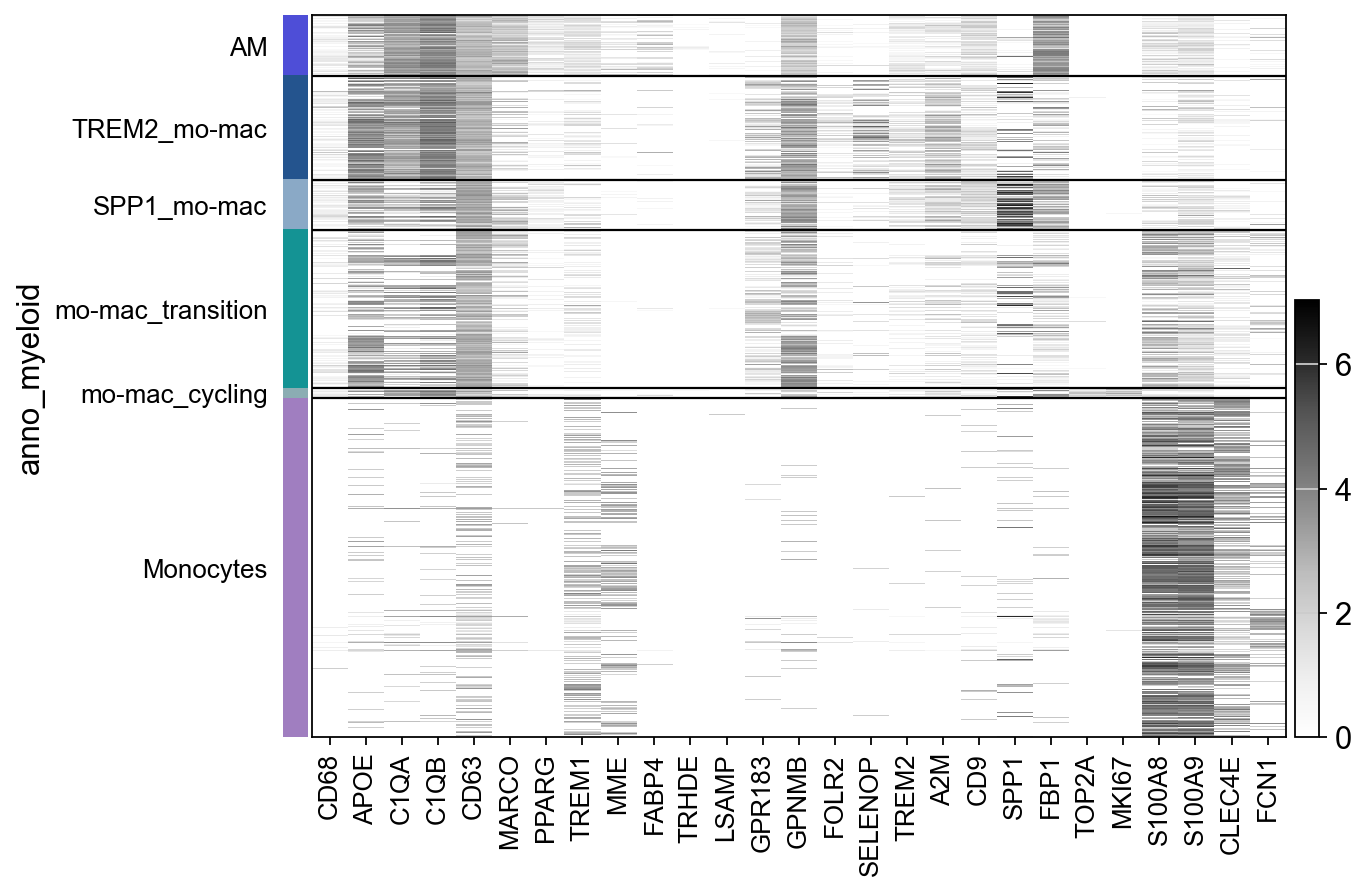

In [ ]:
color_list = ['#D76E63', '#BA3B2F', '#FFA040','#4E4ED7','#24548E','#8AA9C6','#149394','#8BADB3','#A07EC0']
Hu2023.uns['anno_myeloid_colors'] = color_list
Hu2023_momacs = Hu2023[Hu2023.obs['anno_myeloid'].isin(['AM', 'TREM2_mo-mac','SPP1_mo-mac' ,'mo-mac_transition','mo-mac_cycling', 'Monocytes'])]
desired_order = ['AM', 'TREM2_mo-mac','SPP1_mo-mac' ,'mo-mac_transition','mo-mac_cycling', 'Monocytes']
Hu2023_momacs.obs['anno_myeloid'] = Hu2023_momacs.obs['anno_myeloid'].astype('category')
Hu2023_momacs.obs['anno_myeloid'] = Hu2023_momacs.obs['anno_myeloid'].cat.reorder_categories(desired_order)
sc.pl.heatmap(Hu2023_momacs, ["CD68",'APOE',"C1QA", "C1QB",'CD63','MARCO','PPARG','TREM1','MME','FABP4','TRHDE','LSAMP',"GPR183",'GPNMB',"FOLR2",'SELENOP',
                              "TREM2",'A2M','CD9',"SPP1",'FBP1','TOP2A','MKI67',"S100A8","S100A9",'CLEC4E','FCN1'], groupby='anno_myeloid', swap_axes=False, cmap='Greys', save='../yourpath.pdf')


### ChEA-X analysis

In [ ]:
Hu2023_sub = Hu2023[Hu2023.obs['Resource'] == "Post-treatment surgery"]
Hu2023v2_cluster_sub = Hu2023_sub[Hu2023_sub.obs['anno_myeloid'].isin(["SPP1_mo-mac", "TREM2_mo-mac", "mo-mac_transition"])]
sc.tl.rank_genes_groups(Hu2023v2_cluster_sub, 'response', method='wilcoxon')
results = Hu2023v2_cluster_sub.uns['rank_genes_groups']
out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group]*len(results['names'][group])).astype('object'))).T))
    
markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])
markers = markers[(markers.pval_adj < 0.05) & (abs(markers.lfc) > 1)]
markers.to_excel('yourpath/deg.xlsx')
markers_up_NR = markers[markers['pval_adj'] <= 0.05]
markers_up_NR = markers_up_NR[markers_up_NR['lfc'] >= 0.5]
markers_up_NR = markers_up_NR[markers_up_NR['cluster'] == "SD"]
markers_up_NR = list(markers_up_NR['Gene'])

In [ ]:
import gseapy
names = gseapy.get_library_name()
print(names)

In [ ]:
enr_ChIPX_up = gseapy.enrichr(gene_list=markers_up_NR ,gene_sets=['ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X'],organism='Human', outdir='../yourpath',cutoff=0.5 )